# Predicción de Series Temporales con Redes Neuronales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam, SGD, Adamax

In [2]:
PASOS=7

## Usaremos Keras y Tensorflow

Importamos las Librerías que vamos a utilizar

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler

### Cargamos nuestro Dataset

In [8]:
# Leer el archivo CSV en un DataFrame
data = pd.read_csv("AAPL.csv", index_col=0, parse_dates=True)

# Convertir el DataFrame a una Serie
df = data.squeeze()

# Mostrar las primeras filas de la Serie
print(df.head())

FileNotFoundError: [Errno 2] No such file or directory: 'AAPL.csv'

In [ ]:
print(df.index.min())
print(df.index.max())

2017-01-02 00:00:00
2018-11-30 00:00:00


In [ ]:

print(len(df['2018']))

289


In [ ]:
meses =df.resample('M').mean()
meses

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
2018-01-31    201.384615
2018-02-28    190.625000
2018-03-31    174.846154
2018-04-30    186.000000
2018-05-31    190.666667
2018-06-30    196.037037
2018-07-31    289.500000
2018-08-31    309.038462
2018-09-30    230.518519
2018-10-31    209.444444
2018-11-30    184.481481
Freq: M, Name: unidades, dtype: float64

## Visualizaciones

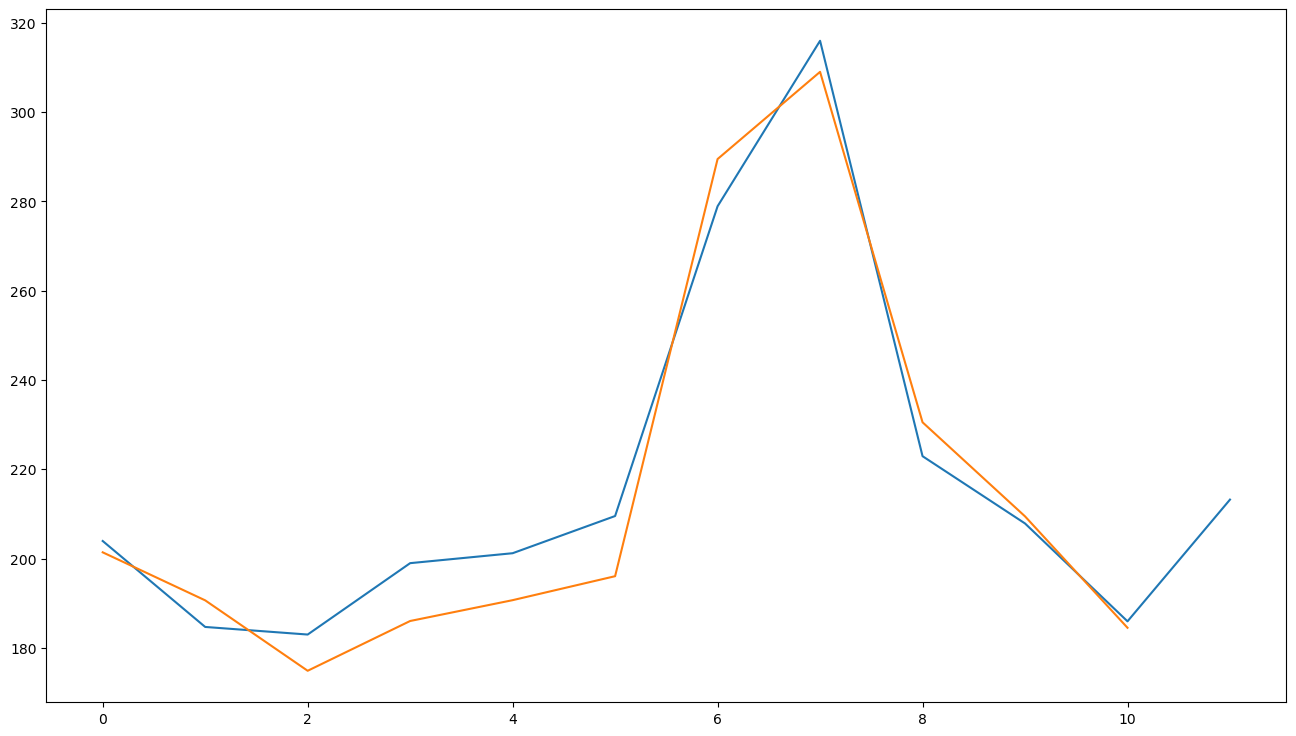

In [ ]:
plt.plot(meses['2017'].values)
plt.plot(meses['2018'].values)


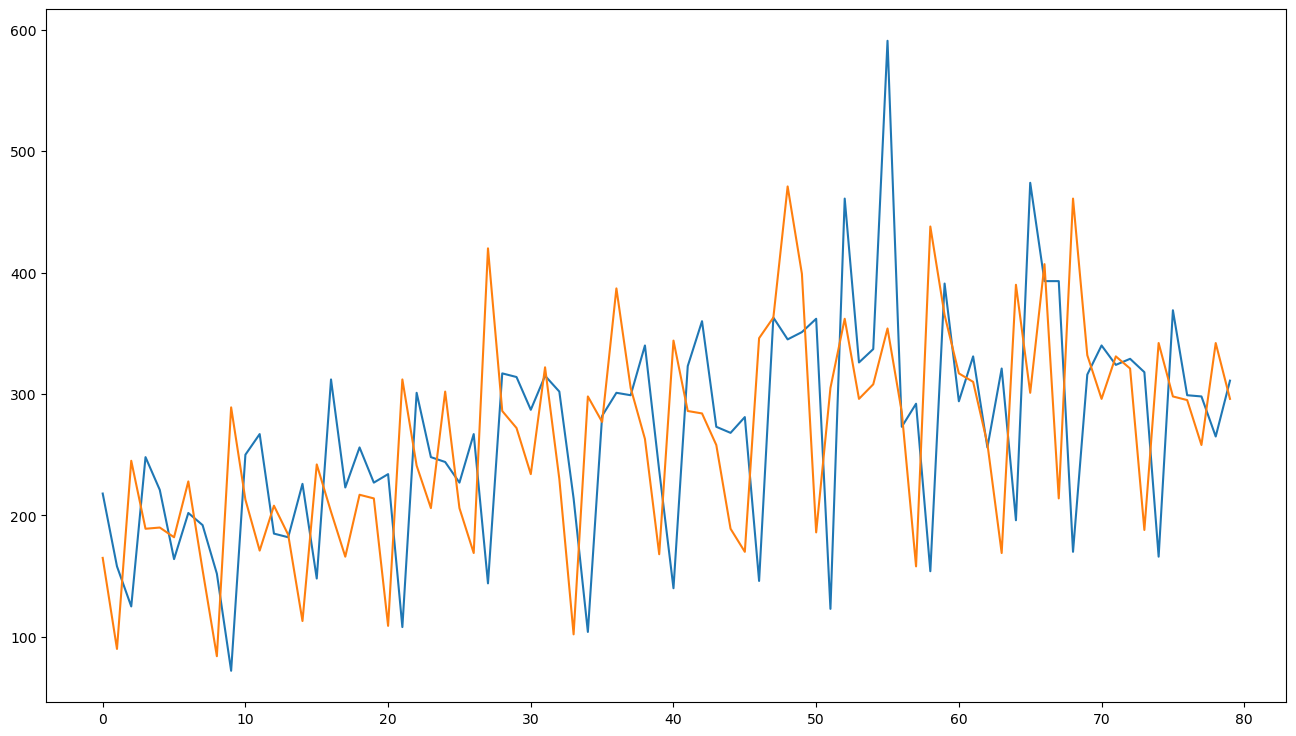

In [ ]:
verano2017 = df['2017-06-01':'2017-09-01']
plt.plot(verano2017.values)
verano2018 = df['2018-06-01':'2018-09-01']
plt.plot(verano2018.values)

# Preprocesado de los datos

In [ ]:


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
values = df.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


## Dividimos en set de Entrenamiento y Validación

In [ ]:
# split into train and test sets
values = reframed.values
n_train_days = 315+289 - (30+PASOS)
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(567, 1, 7) (567,) (30, 1, 7) (30,)


# Tercer (v1) modificación del modelo

## Utilizaremos una Red "normal" Feedforward

In [ ]:

'''
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='SGD',metrics=['mse', 'mae', 'mape'])
    model.summary()
    return model
'''
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='tanh'))
    #optimizer = SGD(learning_rate=0.001)
    model.compile(loss='mean_absolute_error',optimizer='SGD',metrics=['mse', 'mae', 'mape','r2_score'])
    model.summary()
    return model

## Entrenamos nuestra máquina

In [ ]:
EPOCHS=250


model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

C:\Users\alfmi\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1, 7)           │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 345 (1.35 KB)

 Trainable params: 345 (1.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2675 - mae: 0.2675 - mape: 341594.6875 - mse: 0.1124 - r2_score: -0.5717 - val_loss: 0.1875 - val_mae: 0.1875 - val_mape: 44.8996 - val_mse: 0.0587 - val_r2_score: -0.3357
Epoch 2/250
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 0.1942 - mae: 0.1942 - mape: 369429.0000 - mse: 0.0623 - r2_score: 0.1741 - val_loss: 0.1628 - val_mae: 0.1628 - val_mape: 49.9133 - val_mse: 0.0439 - val_r2_score: 0.0011
Epoch 3/250
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 0.1878 - mae: 0.1878 - mape: 42626.6133 - mse: 0.0584 - r2_score: 0.2166 - val_loss: 0.1630 - val_mae: 0.1630 - val_mape: 48.5859 - val_mse: 0.0438 - val_r2_score: 0.0041
Epoch 4/250
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1939 - mae: 0.1939 - mape: 560260.6875 - mse: 0.0644 - r2_score: 0.2263 - val_loss: 0.1629 - val_mae: 0.1629 - val_mape: 48.6740 - val_mse: 0.0436 - val_r2_score: 0.0083
Epoch 5/250
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 0.1813 - m

## Visualizamos Resultados

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
30


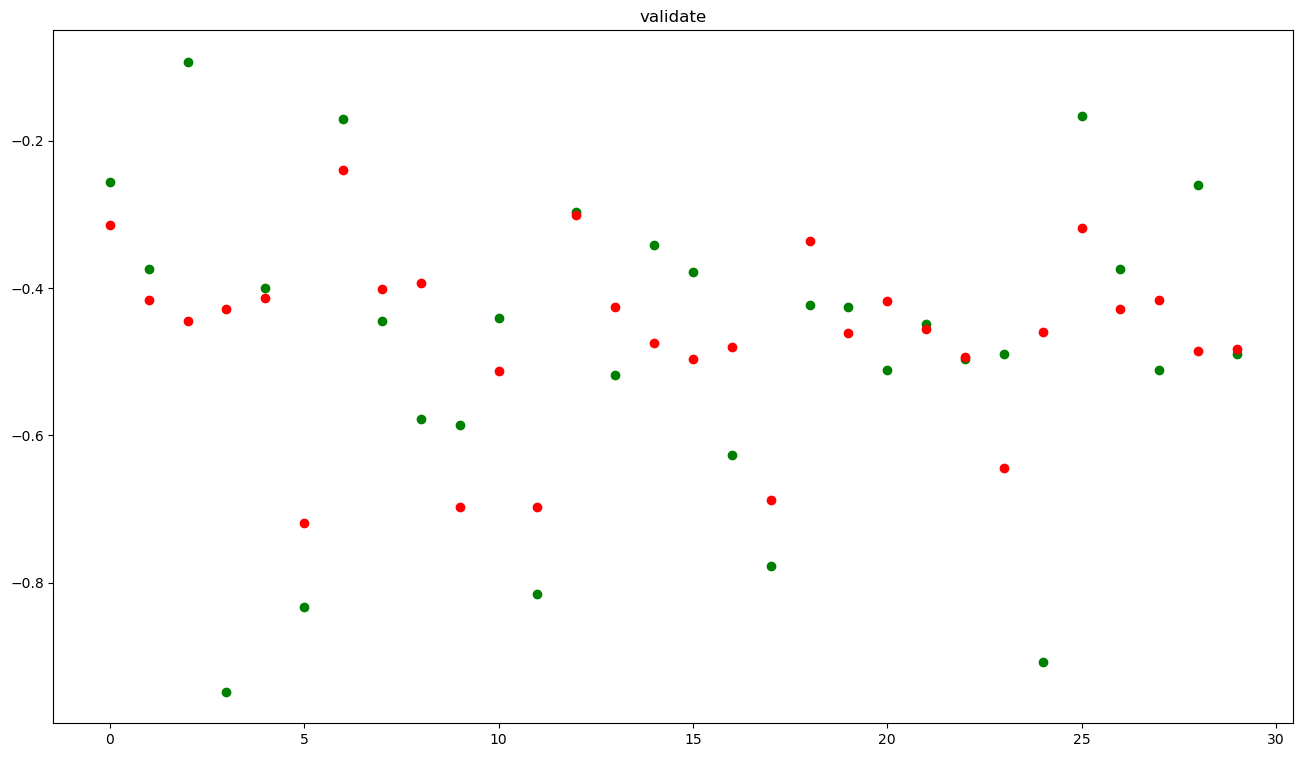

In [ ]:
results=model.predict(x_val)
print( len(results) )
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.show()


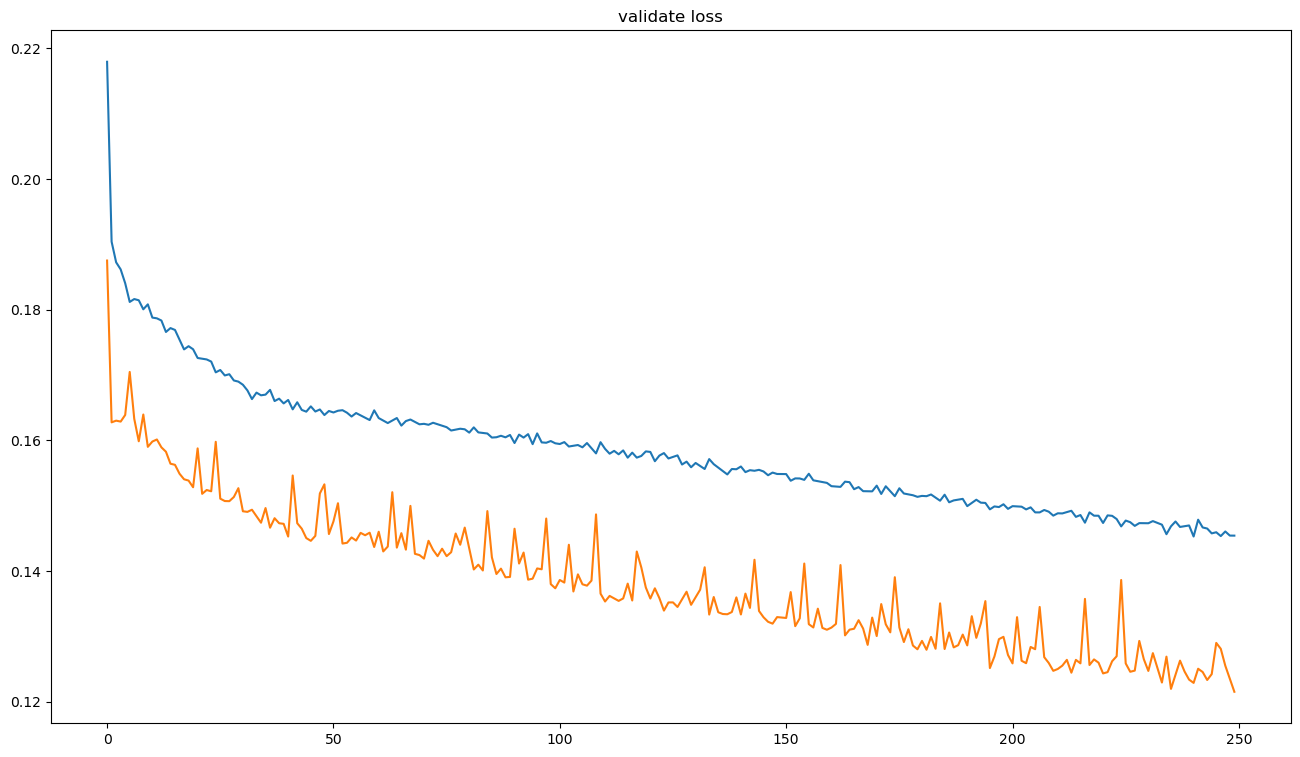

In [ ]:
plt.plot(history.history['loss'])
plt.title('loss')
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.show()

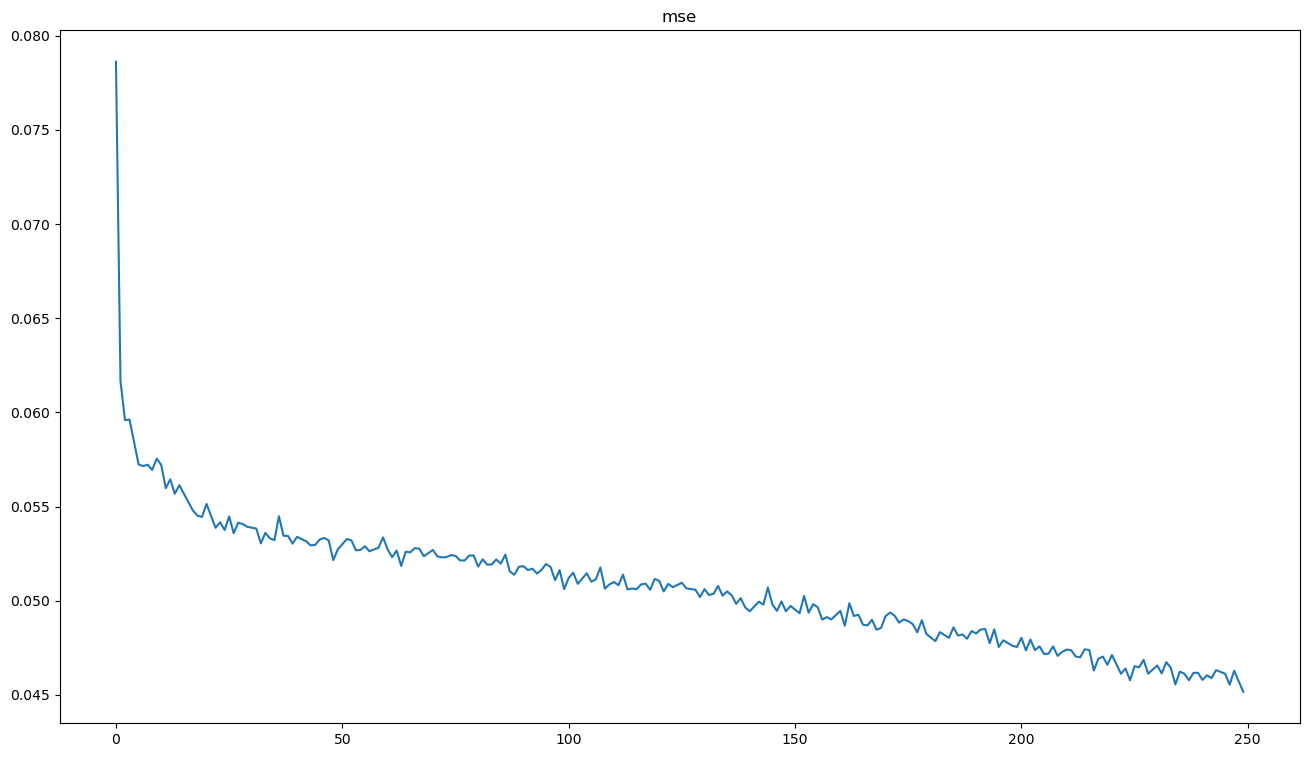

In [ ]:
plt.plot(history.history['mse'])
plt.title('mse')
plt.show()

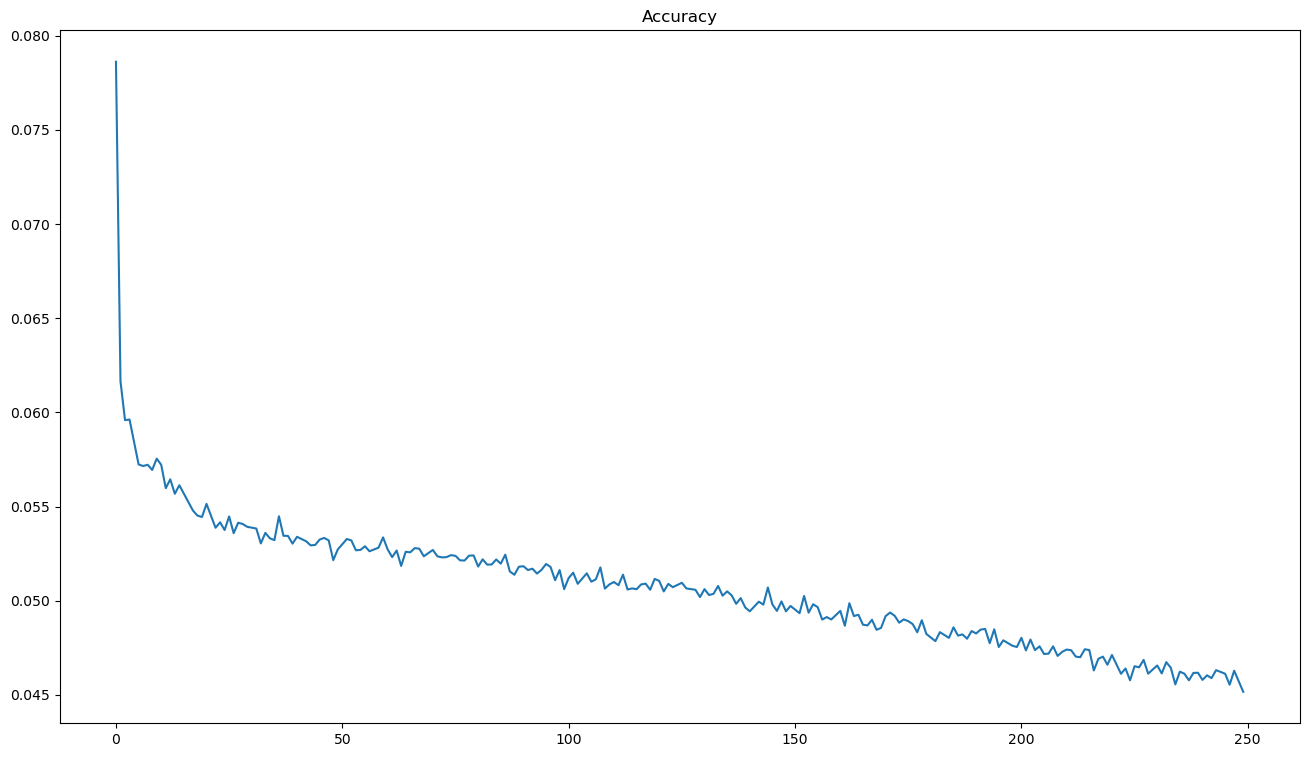

In [ ]:
plt.plot(history.history['mse'])
plt.title('Accuracy')
plt.show()

In [ ]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = compara2['real'] - compara2['prediccion']
compara2.head()

,real,prediccion,diferencia
0,252.000000,235.973495,16.026505
1,220.000000,208.484024,11.515976
2,296.000000,200.893829,95.106171
3,64.999992,205.333542,-140.333557
4,213.000000,209.523773,3.476227


In [ ]:
compara2.describe()

,real,prediccion,diferencia
count,30.000000,30.000000,30.000000
mean,191.633331,195.541946,-3.908611
std,57.580811,32.558487,46.943546
min,64.999992,126.792282,-140.333557
25%,169.000000,188.331802,-25.397106
50%,200.500000,199.529564,1.586510
75%,220.000000,209.317352,19.131538
max,296.000000,256.365204,95.106171


In [ ]:
# Calcular métricas de rendimiento
mse = mean_squared_error(compara2['real'], compara2['prediccion'])
rmse = mse ** 0.5
mae = mean_absolute_error(compara2['real'], compara2['prediccion'])
r2 = r2_score(compara2['real'], compara2['prediccion'])

# Mostrar resultados
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')

Root Mean Squared Error (RMSE): 46.319726789390174
Mean Absolute Error (MAE): 32.80998229980469
R^2 Score: 0.3305785059928894


<Axes: >

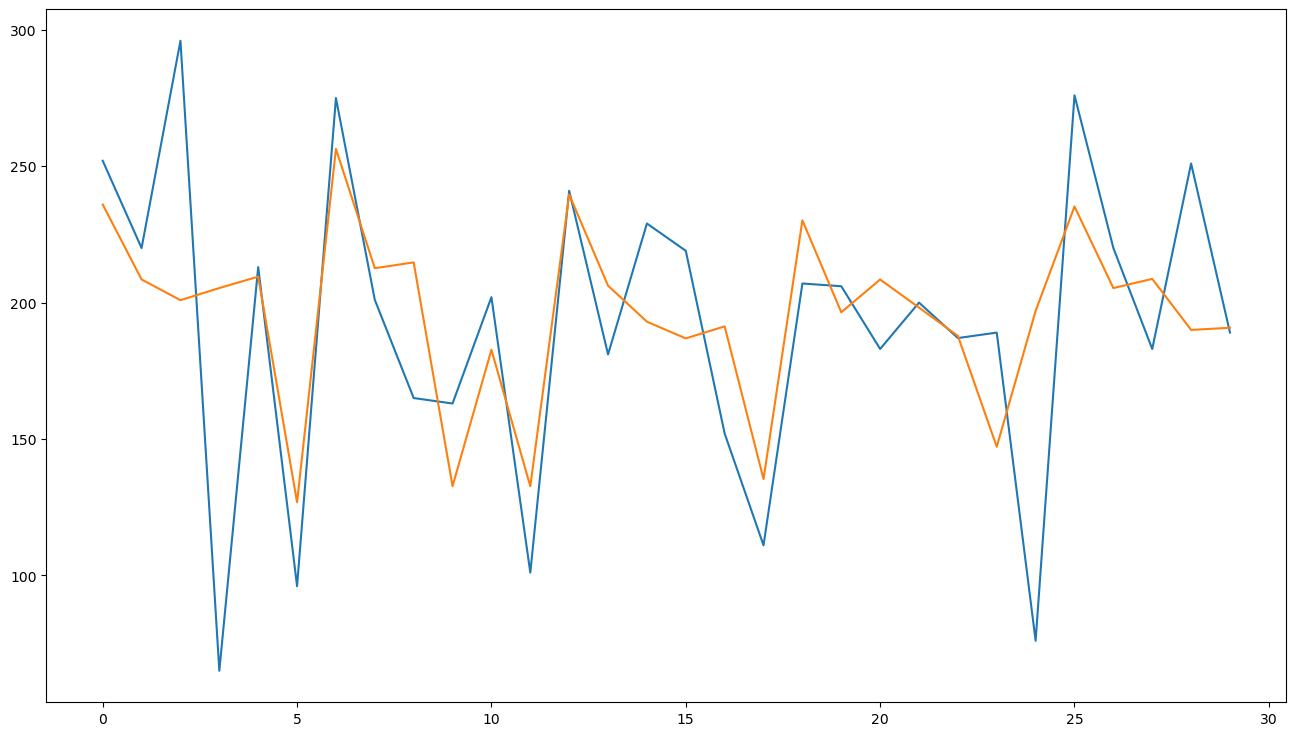

In [ ]:
compara2['real'].plot()
compara2['prediccion'].plot()

## Predicción

A partir de la última semana de noviembre 2018, intentaremos predecir la primer semana de diciembre.

In [ ]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

fecha
2018-11-16    152
2018-11-17    111
2018-11-19    207
2018-11-20    206
2018-11-21    183
2018-11-22    200
2018-11-23    187
2018-11-24    189
2018-11-25     76
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, dtype: int64

### Preparamos los datos para Test

In [ ]:
values = ultimosDias.values
values = values.astype('float32')
# normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, PASOS, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07
13,0.11,0.13,-1.00,1.00,0.44,0.07,0.75


In [ ]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
print(x_test.shape)
x_test

(1, 1, 7)


array([[[ 0.11000001,  0.13      , -1.        ,  1.        ,
          0.44000006,  0.06999993,  0.75      ]]], dtype=float32)

In [ ]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

### Pronóstico para la "próxima semana"

In [ ]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[[ 0.11000001  0.13       -1.          1.          0.44000006
    0.06999993  0.75      ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[[ 0.13       -1.          1.          0.44000006  0.06999993
    0.75       -0.3140699 ]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[[-1.          1.          0.44000006  0.06999993  0.75
   -0.3140699  -0.13661748]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[[ 1.          0.44000006  0.06999993  0.75       -0.3140699
   -0.13661748  0.09260412]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

C:\Users\alfmi\AppData\Local\Temp\ipykernel_39336\3877792702.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0][0][x_test.shape[2]-1]=nuevoValor


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[[[ 0.44000006  0.06999993  0.75       -0.3140699  -0.13661748
    0.09260412  0.15009643]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[[ 0.06999993  0.75       -0.3140699  -0.13661748  0.09260412
    0.15009643 -0.03053931]]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[[ 0.75       -0.3140699  -0.13661748  0.09260412  0.15009643
   -0.03053931 -0.12314873]]]


### Re-Convertimos los resultados

In [ ]:
adimen = [x for x in results]    
print(adimen)
inverted = scaler.inverse_transform(adimen)
inverted

[array([-0.3140699], dtype=float32), array([-0.13661748], dtype=float32), array([0.09260412], dtype=float32), array([0.15009643], dtype=float32), array([-0.03053931], dtype=float32), array([-0.12314873], dtype=float32), array([-0.0836021], dtype=float32)]


array([[144.59301258],
       [162.3382545 ],
       [185.26041549],
       [191.00964645],
       [172.94607214],
       [163.68512952],
       [167.63979273]])

### Visualizamos el pronóstico

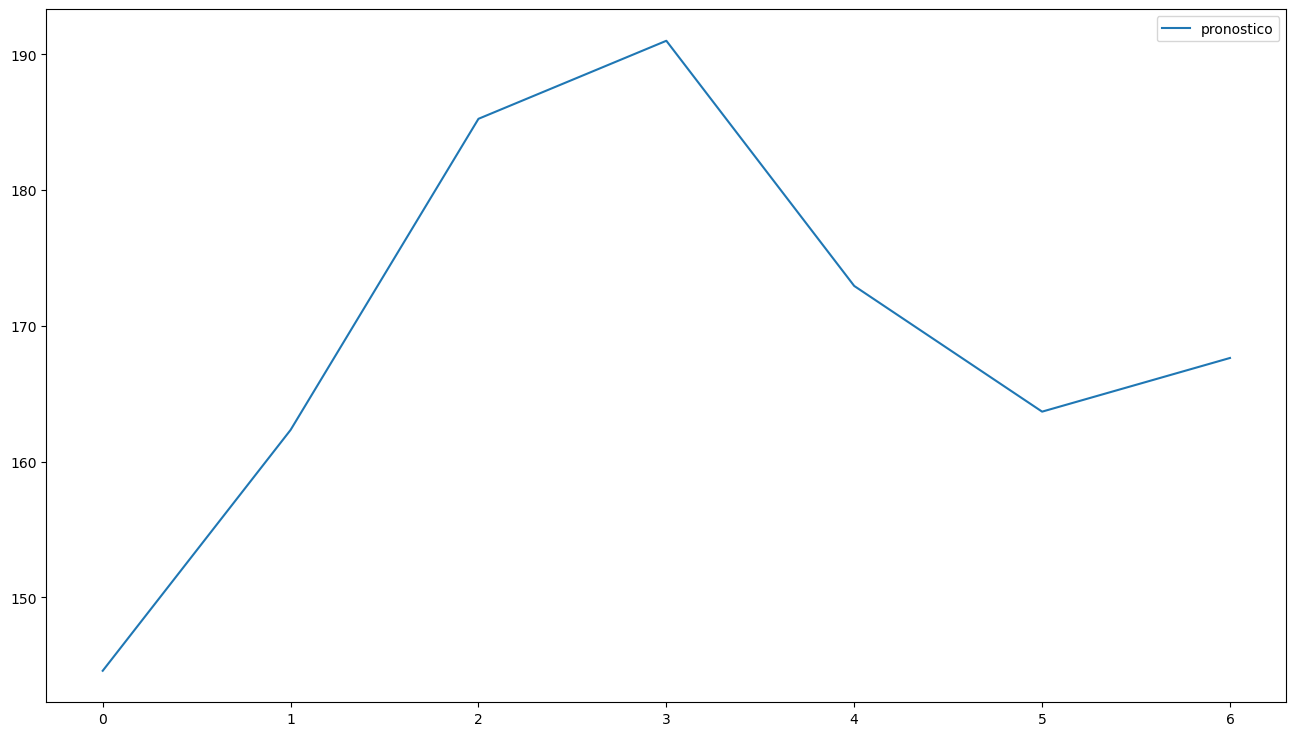

In [ ]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['pronostico']
prediccion1SemanaDiciembre.plot()
prediccion1SemanaDiciembre.to_csv('pronostico.csv')

In [ ]:
prediccion1SemanaDiciembre

,pronostico
0,144.593013
1,162.338255
2,185.260415
3,191.009646
4,172.946072
5,163.685130
6,167.639793
